In [2]:
!pip3 install pickle5

     |████████████████████████████████| 256 kB 12.9 MB/s 


In [3]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import PIL.ImageOps
from tqdm import tqdm
import pickle5 as pickle
import torchvision.models as models
import torchvision.transforms as tt
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from utils import get_args, check_args
import matplotlib.pyplot as plt
# from accuracies import (dev_acc_and_loss, accuracy, approx_train_acc_and_loss)

In [ ]:
# !unzip adience_dataset_preprocessed_v2.zip

In [2]:
!nvidia-smi

Sat May  7 05:13:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
os.getcwd()

'/content'

In [2]:
# accuracy function, by Mark Dredze
# def accuracy(y : np.ndarray, y_hat : np.ndarray) -> np.float64:
def accuracy(y, y_hat):
    """Calculate the simple accuracy given two numpy vectors, each with int values corresponding to each class.

    Args:
        y (np.ndarray): actual value
        y_hat (np.ndarray): predicted value

    Returns:
        np.float64: accuracy
    """
    ### TODO Implement accuracy function
    # y = torch.from_numpy(y)
    # y_hat = torch.from_numpy(y_hat)
    # if torch.cuda.is_available():
    #     y = y.cuda()
    #     y_hat = y_hat.cuda()
    num_correct = 0
    for i in range(len(y)):
        if y[i] == y_hat[i]:
            num_correct += 1
    acc = num_correct/len(y)
    return acc
    
    # raise NotImplementedError


# def approx_train_acc_and_loss(model, train_data : np.ndarray, train_labels : np.ndarray) -> np.float64:
def approx_train_acc_and_loss(model, train_data, train_labels):
    """Given a model, training data and its associated labels, calculate the simple accuracy when the 
    model is applied to the training dataset.
    This function is meant to be run during training to evaluate model training accuracy during training.

    Args:
        model (pytorch model): model class object.
        train_data (np.ndarray): training data
        train_labels (np.ndarray): training labels

    Returns:
        np.float64: simple accuracy
    """
    # x = torch.from_numpy(train_data.astype(np.float32))
    # y = torch.from_numpy(train_labels.astype(np.int))
    # idxs = np.random.choice(len(train_data), 1000, replace=False) # for normal use
    idxs = np.random.choice(len(train_data), 700, replace=False) # for convNext Large
    x = torch.from_numpy(train_data[idxs].astype(np.float32))
    y = torch.from_numpy(train_labels[idxs].astype(np.int))

    # if torch.cuda.is_available():
    #     x = torch.from_numpy(train_data[idxs].astype(np.float32)).cuda()
    #     y = torch.from_numpy(train_labels[idxs].astype(np.int)).cuda()

    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    # y_pred = np.array([i.item() for i in y_pred]) # to cpu
    return accuracy(train_labels[idxs], y_pred), loss.item()


# def dev_acc_and_loss(model, dev_data : np.ndarray, dev_labels : np.ndarray) -> np.float64:
def dev_acc_and_loss(model, dev_data, dev_labels):
    """Given a model, a validation dataset and its associated labels, calcualte the simple accuracy when the
    model is applied to the validation dataset.
    This function is meant to be run during training to evaluate model validation accuracy.

    Args:
        model (pytorch model): model class obj
        dev_data (np.ndarray): validation data
        dev_labels (np.ndarray): validation labels

    Returns:
        np.float64: simple validation accuracy
    """
    # idxs = np.random.choice(len(dev_data), 1000, replace=False) # for normal use
    idxs = np.random.choice(len(dev_data), 700, replace=False) # for convNext Large
    x = torch.from_numpy(dev_data[idxs].astype(np.float32))
    y = torch.from_numpy(dev_labels[idxs].astype(np.int))

    # if torch.cuda.is_available():    
    #     x = torch.from_numpy(dev_data.astype(np.float32)).cuda()
    #     y = torch.from_numpy(dev_labels.astype(np.int)).cuda()
    
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    # y_pred = np.array([i.item() for i in y_pred]) # to cpu
    return accuracy(dev_labels[idxs], y_pred), loss.item()


In [3]:
# DATA_DIR = os.getcwd() + "/adience_dataset_preprocessed_v2/"
DATA_DIR = os.getcwd() + "/adience_dataset_preprocessed/"
# LABEL_DIR = "data/sentiment/fer2013.csv"

TRAIN_DIR = DATA_DIR + "train/"
VAL_DIR = DATA_DIR + "val/"
MODEL_DIR = "models/"

age_groups = [0,1,2,3,4,5,6,7]

# age_groups for overall dataset
# [0-4): 0 2509
# [4-8): 1 2140
# [8-15): 2 2288
# [15-25): 3 1887
# [25-38): 4 5495
# [38-48): 5 2435
# [48-60): 6 930
# [60-100): 7 867

# to.tensor convert the images to range (0,1) and then normalize them
train_transform = tt.Compose([tt.ToTensor(),tt.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
valid_transform = tt.Compose([tt.ToTensor(),tt.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

# read train images labels
# train image
with open(TRAIN_DIR + 'img_array_train.pkl', "rb") as fh: # open up a pickle file
    TRAIN_IMAGES_pkl = pickle.load(fh)
TRAIN_IMAGES_array = TRAIN_IMAGES_pkl.to_numpy() # convert to numpy array
TRAIN_IMAGES = [] # append each image array to the list
for i in range(len(TRAIN_IMAGES_array)):
    train_image = np.stack((TRAIN_IMAGES_array[i][0],)*3, axis = -1)
    train_image = np.array(train_transform(train_image))
    # TRAIN_IMAGES.append((TRAIN_IMAGES_array[i][0]))
    # TRAIN_IMAGES.append(np.stack((TRAIN_IMAGES_array[i][0],)*3, axis=-1)) 
    TRAIN_IMAGES.append(train_image)
TRAIN_IMAGES = np.array(TRAIN_IMAGES) # convert the list to array

# train label
with open(TRAIN_DIR + 'age_groups_train.pkl', "rb") as fh: # open up a pickle file
    age_groups_pkl = pickle.load(fh)
# flat labels
age_groups_array = age_groups_pkl.to_numpy()
TRAIN_AGE_LABELS = [] # append each image label to the list
for i in range(len(age_groups_array)):
    TRAIN_AGE_LABELS.append(age_groups_array[i][0]) # flat the labels
TRAIN_AGE_LABELS = np.array(TRAIN_AGE_LABELS) # convert the list to array

# valid image
with open(VAL_DIR + 'img_array_val.pkl', "rb") as fh: # open up a pickle file
    VALID_IMAGES_pkl = pickle.load(fh)
VALID_IMAGES_array = VALID_IMAGES_pkl.to_numpy() # convert to numpy array
VALID_IMAGES = [] # append each image array to the list
for i in range(len(VALID_IMAGES_array)):
    val_image = np.stack((VALID_IMAGES_array[i][0],)*3, axis = -1)
    val_image = np.array(valid_transform(val_image))
    # TRAIN_IMAGES.append((TRAIN_IMAGES_array[i][0]))
    # TRAIN_IMAGES.append(np.stack((TRAIN_IMAGES_array[i][0],)*3, axis=-1)) 
    VALID_IMAGES.append(val_image)
    # VALID_IMAGES.append(np.stack((VALID_IMAGES_array[i][0],)*3, axis=-1)) # 
VALID_IMAGES = np.array(VALID_IMAGES) # convert the list to array

# valid label
with open(VAL_DIR + 'age_groups_val.pkl', "rb") as fh: # open up a pickle file
    age_groups_val_pkl = pickle.load(fh)
# flat labels
age_groups_val_array = age_groups_val_pkl.to_numpy() # convert to array 
VALID_AGE_LABELS = [] # append each image label to the list
for i in range(len(age_groups_val_array)):
    VALID_AGE_LABELS.append(age_groups_val_array[i][0]) # flat the labels
VALID_AGE_LABELS = np.array(VALID_AGE_LABELS) # convert the list to array


# some parameters
N_IMAGES = TRAIN_IMAGES.shape[0]
HEIGHT = TRAIN_IMAGES.shape[1]
WIDTH = TRAIN_IMAGES.shape[2]
N_CLASSES = len(np.unique(TRAIN_AGE_LABELS))

# image preprocessing (iamges are randomly rotated already)
# only normalize the images
# train_transform = tt.Compose([tt.ToTensor(),tt.Normalize(0.5,0.5)])
# valid_transform = tt.Compose([tt.ToTensor(),tt.Normalize(0.5,0.5)])
# TRAIN_IMAGES = np.array(train_transform(TRAIN_IMAGES))
# VALID_IMAGES = np.array(valid_transform(VALID_IMAGES))

# convert to 3 channel input
# TRAIN_IMAGES = np.stack((TRAIN_IMAGES,)*3, axis=-1)
# VALID_IMAGES = np.stack((VALID_IMAGES,)*3, axis=-1)


# reshape to for batch training
# grey scale image
# TRAIN_IMAGES = TRAIN_IMAGES.reshape(-1,1,HEIGHT,WIDTH)
# VALID_IMAGES = VALID_IMAGES.reshape(-1,1,HEIGHT,WIDTH)
# convert grey scale image to 3 input channel
# TRAIN_IMAGES = TRAIN_IMAGES.reshape(-1,3,HEIGHT,WIDTH) # shape (10471, 3, 256, 256)
# VALID_IMAGES = VALID_IMAGES.reshape(-1,3,HEIGHT,WIDTH)

# normalize
# train_transform = tt.Compose([tt.ToTensor(),tt.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
# valid_transform = tt.Compose([tt.ToTensor(),tt.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
# TRAIN_IMAGES = np.array(train_transform(TRAIN_IMAGES))
# VALID_IMAGES = np.array(valid_transform(VALID_IMAGES))



In [10]:
# TRAIN_IMAGES.shape # (10471, 3, 300, 300)
# VALID_IMAGES.shape # (3490, 3, 300, 300)

(10471, 3, 48, 48)

In [11]:
# TRAIN_IMAGES = torch.from_numpy(TRAIN_IMAGES).cuda()
# TRAIN_AGE_LABELS = torch.from_numpy(TRAIN_AGE_LABELS).cuda()
# VALID_IMAGES = torch.from_numpy(VALID_IMAGES).cuda()
# VALID_AGE_LABELS = torch.from_numpy(VALID_AGE_LABELS).cuda()

In [17]:
# alexnet baselien, highest train/val acc: 0.35/0.31 -- bs 64, lr 0.001 epoch 40

# use pretrained alexnet model and edit the structures of it
# model = torchvision.models.alexnet(pretrained=True)
# model.features._modules['0'] =  torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
# model.classifier._modules['6'] = torch.nn.Linear(4096,N_CLASSES)
# if torch.cuda.is_available():
#     model = model.cuda()


In [ ]:
# inception v3, cannot run

# use pretrained model and edit the structures of it
# model = torchvision.models.inception_v3(pretrained=True)
# model.Conv2d_1a_3x3.conv = torch.nn.Conv2d(in_channels=1, # input channel = 1
#                                 out_channels=32,
#                                 kernel_size=(3, 3),
#                                 stride=(2, 2),
#                                 bias = False)
# model.fc = torch.nn.Linear(2048,N_CLASSES)
# if torch.cuda.is_available():
#     model = model.cuda()
# model.aux_logits=False


In [19]:
# resnext50_32_4, highest train/val acc: 0.85/0.6 -- bs 256, lr 0.0005 epoch 100
# model = models.resnext50_32x4d(pretrained=True)
# model.fc = torch.nn.Linear(2048,N_CLASSES)
# model = model.cuda()

In [21]:
# efficientnet (not able to use cuda), highest train/val acc: 0.46/0.43 -- bs 64, lr 0.0005 epoch 40

# model = models.efficientnet_b6(pretrained=True)
# model.classifier._modules['1'] = torch.nn.Linear(2304,N_CLASSES)

In [4]:
# vit_b_16, cannot run because it requires specific image height

# model = models.vit_b_16(pretrained=True)
# model.heads = torch.nn.Linear(768,N_CLASSES)

In [5]:
# regnet_x_32gf, 
# highest train/val acc: 
# 0.89/0.66 -- bs 128, lr 0.0005 epoch 100
# 0.88/0.65 -- bs 256, lr 0.0005 epoch 100

# model = models.regnet_x_32gf(pretrained=True)
# model.fc = torch.nn.Linear(2520,N_CLASSES)
# model = model.cuda()

In [6]:
# convNext_base, 
# highest train/val acc: 
# 0.87/0.67 --bs 256 lr 0.0005 epoch 100
# 0.93/0.70 --bs 400 lr 0.0005 epoch 100
# 0.93/0.69 --bs 400 lr 0.0001 epoch 200

model = models.convnext_base(pretrained=True)
# model.classifier._modules['2']
model.classifier._modules['2'] = torch.nn.Linear(1024,N_CLASSES)
# model = model.cuda()

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

In [5]:
# convNext_large, 
# highest train/val acc: 
# 0.86/0.71 --bs 256 lr 0.0005 epoch 100 (accuracy calculated with size 500 only due to limited GPU memory)
# 0.85/0.67 --bs 200 lr 0.0005 epoch 100 (accuracy calculated with size 700 only due to limited GPU memory)

# model = models.convnext_large(pretrained=True)
# # model.classifier
# model.classifier._modules['2'] = torch.nn.Linear(1536,N_CLASSES)
# model = model.cuda()

In [ ]:
# models.convnext_large

In [ ]:
# # check structure
model

In [ ]:
# some parameters
BATCH_SIZE = 200
EPOCH = 100
LR = 0.0005 

loss_function = F.cross_entropy
train_loss_=[]
val_loss_=[]
train_acc_=[]
val_acc_=[]

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for step in tqdm(range(EPOCH)):
    model.train()    
    print('starting the {} epoch'.format(step+1))
    i = np.random.choice(TRAIN_IMAGES.shape[0], size=BATCH_SIZE, replace=False)
    x = torch.from_numpy(TRAIN_IMAGES[i].astype(np.float32))
    y = torch.from_numpy(TRAIN_AGE_LABELS[i].astype(np.int))
    
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    # Forward pass: Get logits for x
    logits = model(x)
    # Compute loss
    loss = loss_function(logits, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print the current result
    train_acc, train_loss = approx_train_acc_and_loss(model, TRAIN_IMAGES, TRAIN_AGE_LABELS)
    val_acc, val_loss = dev_acc_and_loss(model, VALID_IMAGES, VALID_AGE_LABELS)
    train_acc_.append(train_acc)
    val_acc_.append(val_acc)
    train_loss_.append(train_loss)
    val_loss_.append(val_loss)
    # print(f"On step {step}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")
    print("{}/{} Epochs  | Train Loss={:.4f}  |Train_Accuracy={:.4f} |Val_loss={:.4f}  |Val_Accuracy={:.4f}".format(step+1,EPOCH,train_loss,train_acc,val_loss,val_acc)  )

# save model
# torch.save(model, os.getcwd() + "/regnet_x_32gf_bs256_lr00005_epoch100.pt")

In [9]:
# save model
torch.save(model, os.getcwd() + "/convnext_large_bs256_lr00005_epoch100.pt")

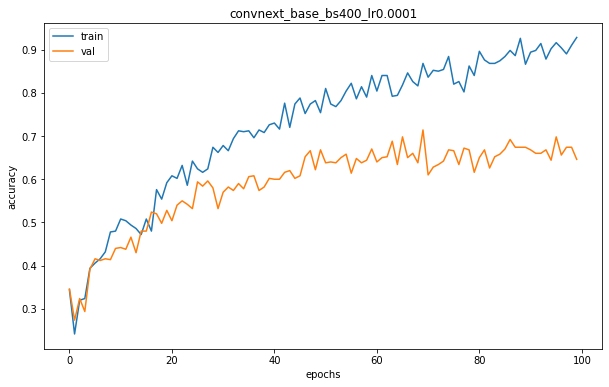

In [7]:
plt.figure(figsize=(10,6))
plt.plot(range(len(train_acc_)),train_acc_, label = 'train')
plt.plot(range(len(val_acc_)),val_acc_, label = 'val')
plt.legend()
plt.title('convnext_base_bs400_lr0.0001')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
# plt.savefig('ResNext50_32_4d_bs128_lr0.001.jpg')


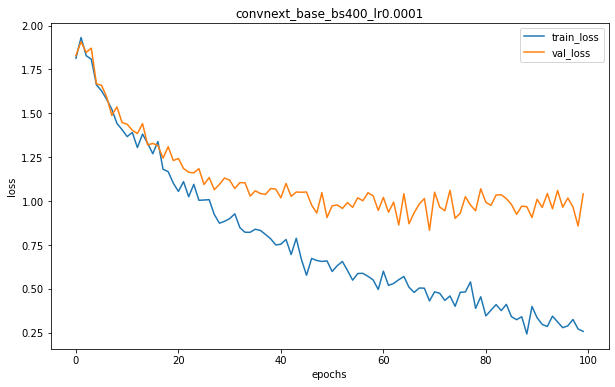

In [8]:
plt.figure(figsize=(10,6))
plt.plot(range(len(train_loss_)),train_loss_, label = 'train_loss')
plt.plot(range(len(val_loss_)),val_loss_, label = 'val_loss')
plt.legend()
plt.title('convnext_base_bs400_lr0.0001')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [19]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# RESULT

'''

1. alexnet baseline, highest train/val acc: 0.35/0.31 -- bs 64, lr 0.001 epoch 40
2. inception v3, it requires very large pcitures
3. resnext50_32_4, highest train/val acc: 0.52/0.46 -- bs 128, lr 0.001 epoch 40
4. efficientnet, highest train/val acc: 0.46/0.43 -- bs 64, lr 0.0005 epoch 40
5. vit_b_16, cannot run because it requires specific image height
6. regnet_x_32gf, highest train/val acc: 0.89/0.66 -- bs 128, lr 0.0005 epoch 100
        0.89/0.66 -- bs 128, lr 0.0005 epoch 100
        0.88/0.65 -- bs 256, lr 0.0005 epoch 100
*7. convNext_base, 
highest train/val acc: 
        0.87/0.67 --bs 256 lr 0.0005 epoch 100 
        0.93/0.70 --bs 400 lr 0.0005 epoch 100
        0.93/0.69 --bs 400 lr 0.0001 epoch 200
8. convNext_large, 
highest train/val acc: 
        0.86/0.71 --bs 256 lr 0.0005 epoch 100 (accuracy calculated with size 500 only due to limited GPU memory)
        0.85/0.67 --bs 200 lr 0.0005 epoch 100 (accuracy calculated with size 700 only due to limited GPU memory)


'''